# MMDetection 
## Documentation: https://mmdetection.readthedocs.io/en/latest/get_started.html

# Check lib versions

In [1]:
%%bash
# Check nvcc version
nvcc -V
echo
# Check GCC version
gcc --version
echo
# Check the version of torch and cuda packages
pip list | grep "torch\|cuda"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0

gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.


cuda-python                   11.6.1
cupy-cuda115                  9.6.0
dask-cuda                     22.4.0
nvidia-dali-cuda110           1.13.0
pytorch-quantization          2.1.2
torch                         1.12.0a0+8a1a93a
torch-tensorrt                1.1.0a0
torchtext                     0.13.0a0
torchvision                   0.13.0a0


# Setup Weights & Biases

In [2]:
# !pip install -q --upgrade wandb


# import os
# os.environ["WANDB_NOTEBOOK_NAME"] = "mmdetecttion_custom_dataset"
# import wandb
# wandb.login()

# wandb.__version__

In [3]:
# import wandb
# import os

# os.environ["WANDB_NOTEBOOK_NAME"] = "mmdetecttion_custom_dataset"

# wandb.init(project="animaltracking", entity="mjirik")

In [4]:
# Some basic setup
import sys
from pathlib import Path

sys.path.insert(0, str(Path(".").absolute().parent.absolute()))

# import some common libraries
import logging
import mmcv.utils

logger = mmcv.utils.get_logger(name="general_logger", log_level=logging.DEBUG)

import matplotlib.pyplot as plt
import numpy as np

# Check Pytorch installation
import torch, torchvision

print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet

logger.debug(f"mmdet.version={mmdet.__version__}")

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

logger.debug(get_compiling_cuda_version())
logger.debug(get_compiler_version())
from pprint import pprint, pformat
from mmdet.datasets import build_dataset
from mmdet.apis import train_detector
from mmcv import Config
from mmdet.apis import set_random_seed
from pathlib import Path
import os.path as osp
import os
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

import skimage
import random
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import requests
import json

def unzip(input_file:Path, output_dir=None):
    from zipfile import ZipFile
    with ZipFile(input_file,"r") as zip_ref:
         for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
              zip_ref.extract(member=file, path=output_dir)
            
def classes_from_coco(annotation_file:Path):
    with open(annotation_file) as f:
        ann = json.load(f)
    _, cfg_classes = zip(*sorted([(cat["id"], cat["name"]) for cat in ann["categories"]]))
    return cfg_classes

def mywget(url, fname, force=False):
    fname = Path(fname)
    if fname.exists() and ~force:
        print(f"File already exists. Use force=True to owerwrite.")
        return
    fname.parent.mkdir(parents=True, exist_ok=True)
    
    response = requests.get(url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(fname, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")
    

2023-04-20 10:34:03,614 - general_logger - DEBUG - mmdet.version=2.25.0


1.12.0a0+8a1a93a True


2023-04-20 10:34:03,885 - general_logger - DEBUG - 11.7
2023-04-20 10:34:03,886 - general_logger - DEBUG - GCC 9.4


NOTE! Installing ujson may make loading annotations faster.


In [5]:
mmdet.__version__
mmdet.__file__ # path where mmdetection is saved - use it in Jupyter notebook terminal 

'/workspace/mmdetection/mmdet/__init__.py'

# Prepare data

Download and copy dataset to scratch dir.

In [6]:
scratchdir = Path(os.getenv("SCRATCHDIR", "."))
logname = Path(os.getenv("LOGNAME", "."))
# from loguru import logger

local_input_data_dir = Path(scratchdir) / "data/orig/" # original data directory
local_output_data_dir = Path(scratchdir) / "data/processed/" # processed data directory

LOCAL_INPUT_DATA_DIR = str(local_input_data_dir)
LOCAL_OUTPUT_DATA_DIR = str(local_output_data_dir)

!echo "$LOCAL_INPUT_DATA_DIR"
!echo "$LOCAL_OUTPUT_DATA_DIR"

/scratch.ssd/jburian/job_15099927.meta-pbs.metacentrum.cz/data/orig
/scratch.ssd/jburian/job_15099927.meta-pbs.metacentrum.cz/data/processed


In [7]:
!pwd # print working directory

/mnt/storage-plzen1/home/jburian/projects/MMDetection_cell_nuclei


In [8]:
!mkdir -p "$LOCAL_INPUT_DATA_DIR"

# 1) copy data from your location or ...
!cp -r ~/data/biomedical/orig/cell_nuclei_COCO.zip "$SCRATCHDIR"/data.zip
# to see progressbar we use 'rsync -ah  instead of cp
# !rsync --progress -ah -r /storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigleg_holder.zip "$SCRATCHDIR"/data.zip

# ... or download from internet
# mywget("https://github.com/Tony607/detectron2_instance_segmentation_demo/releases/download/V0.1/data.zip", scratchdir/"data.zip")
# !wget https://github.com/Tony607/detectron2_instance_segmentation_demo/releases/download/V0.1/data.zip -O "$SCRATCHDIR"/data.zip

# 2) unzip
# !unzip -o "$SCRATCHDIR"/data.zip -d "$LOCAL_INPUT_DATA_DIR" > /dev/null
unzip(scratchdir/"data.zip", local_input_data_dir)

!ls "$LOCAL_INPUT_DATA_DIR"

100%|██████████| 31/31 [00:00<00:00, 445.73it/s]


data  images  test.json  tmp.json  train.json  trainval.json  val.json


In [9]:
# Checking directories 
!echo "$SCRATCHDIR"
!ls "$SCRATCHDIR"
!ls "$SCRATCHDIR"/data/orig

/scratch.ssd/jburian/job_15099927.meta-pbs.metacentrum.cz
checkpoints  data  data.zip
data  images  test.json  tmp.json  train.json  trainval.json  val.json


## Dataset paths

In [10]:
data_root = local_input_data_dir

# data_root = local_input_data_dir
img_prefix = './images'
train_ann_file = 'trainval.json'
val_ann_file  = 'trainval.json'
test_ann_file = 'trainval.json'

data_root

PosixPath('/scratch.ssd/jburian/job_15099927.meta-pbs.metacentrum.cz/data/orig')

### Train test val split

Run the following lines if you want split dataset. Change the dataset configuration in the `mmdetection` config : `cfg.train...`, `cfg.test...` and `cfg.val...`

In [11]:
import coco_dataset
fnin= data_root / 'trainval.json'
# fnin= data_root / 'annotations/instances_default.json'
fn1 = data_root / 'train.json'
fn2 = data_root / 'test.json'
fn3 = data_root / 'val.json'
fntmp = data_root / 'tmp.json'
assert fnin.exists()
ccd = coco_dataset.CocoDataset(fnin, data_root / "images")
ccd.train_test_split(fn1, fntmp) # 1 json => 2 jsony
ccd = coco_dataset.CocoDataset(fntmp, data_root / "images")
ccd.train_test_split(fn2, fn3, 0.5) # + dalsi 2 z druheho 
assert fn3.exists()

train_ann_file = 'train.json'
val_ann_file  = 'val.json'
test_ann_file = 'test.json'


# Prepare pretrained checkpoint
### Configs
- Configs (Faster R-CNN): https://github.com/open-mmlab/mmdetection/tree/master/configs/faster_rcnn
- Configs (Mask R-CNN): https://github.com/open-mmlab/mmdetection/tree/master/configs/mask_rcnn

### Useful file (metafile.yml) for getting urls to download pretrained models:
- Faster R-CNN: https://github.com/open-mmlab/mmdetection/blob/master/configs/faster_rcnn/metafile.yml 
- Mask R-CNN: https://github.com/open-mmlab/mmdetection/blob/master/configs/mask_rcnn/metafile.yml

In [12]:
# main_url_to_download_model = "https://download.openmmlab.com/mmdetection/v2.0"
# path_to_model = '/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth' # mutable parameter, depends on wanted model

# wget_url = main_url_to_download_model + path_to_model
# model_name_test = os.path.basename(path_to_model).split('/')[-1]
# configs_dir = os.path.split(path_to_model)[0] + ".py"

# # Getting relevant model 
# mywget(
#     wget_url,
#     scratchdir
#     / str("checkpoints/" + model_name)
# )

# print(wget_url)
# print(model_name_test)
# print(configs_dir)
# print(type(configs_dir))
# print(type(model_name_test))
# print(type(wget_url))

# mywget(
#     "https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_fpn_2x_coco/mask_rcnn_r50_fpn_2x_coco_bbox_mAP-0.392__segm_mAP-0.354_20200505_003907-3e542a40.pth",
#     scratchdir
#     / "checkpoints/mask_rcnn_r50_fpn_2x_coco_bbox_mAP-0.392__segm_mAP-0.354_20200505_003907-3e542a40.pth"
# )

mywget(
    "https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_caffe_fpn_1x_coco/mask_rcnn_r101_caffe_fpn_1x_coco_20200601_095758-805e06c1.pth",
    scratchdir
    / "checkpoints/mask_rcnn_r101_caffe_fpn_1x_coco_20200601_095758-805e06c1.pth"
)

File already exists. Use force=True to owerwrite.


In [13]:
cfg_classes = classes_from_coco(data_root / train_ann_file)
print(cfg_classes)


mmdetection_path = Path(mmdet.__file__).parent.parent

logger.debug(f"outputdir={local_output_data_dir}")
logger.debug(f"input_data_dir={local_input_data_dir}")
logger.debug(f"input_data_dir exists={local_input_data_dir.exists()}")
logger.debug(f'input_data_dir glob={str(list(local_input_data_dir.glob("**/*")))}')

# Choose to use a config and initialize the detector
# test_str = str("configs" + configs_dir)
# test_str = "configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py"
# print(test_str)
# config = (
#     mmdetection_path 
#     / test_str
# )

config = (
    mmdetection_path
    / "configs/mask_rcnn/mask_rcnn_r101_caffe_fpn_1x_coco.py"
)


logger.debug(f"config.exists={config.exists()}")

# Setup a checkpoint file to load
# test_str = str("checkpoints/" + model_name_test)
# test_str = "checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth"
# print(test_str)
# checkpoint_pth = (
#     scratchdir
#     / test_str
# )

checkpoint_pth = (
    scratchdir
    / "checkpoints/mask_rcnn_r101_caffe_fpn_1x_coco_20200601_095758-805e06c1.pth"
)
print(checkpoint_pth)
logger.debug(f"checkpoint_pth.exists={checkpoint_pth.exists()}")

# Set the device to be used for evaluation
device = "cuda:0"

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, str(checkpoint_pth), map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint["meta"]["CLASSES"]

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

# Use the detector to do inference
img = mmdetection_path / "demo/demo.jpg"
result = inference_detector(model, img)
model.show_result(
    img, result, out_file=local_output_data_dir / "demo_output.jpg"
)  # save image with result


# My dataset training
# test_str = str("configs" + configs_dir)
# test_str = "configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py"
# cfg = Config.fromfile(
#     mmdetection_path
#     / test_str
# )

cfg = Config.fromfile(
    mmdetection_path
    / "configs/mask_rcnn/mask_rcnn_r101_caffe_fpn_1x_coco.py"
)

# Modify dataset type and path
cfg.dataset_type = "CocoDataset"
cfg.data_root = str(local_input_data_dir)

cfg.classes = cfg_classes


## Coco train, val and test datasets definition
cfg.data.test.type = 'CocoDataset'
cfg.data.test.data_root = str(data_root)
cfg.data.test.ann_file = test_ann_file
# cfg.data.test.ann_file = 'test.json'
cfg.data.test.img_prefix = img_prefix
cfg.data.test.classes = cfg.classes

cfg.data.train.type = 'CocoDataset'
cfg.data.train.data_root = str(data_root)
cfg.data.train.ann_file = train_ann_file
# cfg.data.test.ann_file = 'train.json'
cfg.data.train.img_prefix = img_prefix
cfg.data.train.classes = cfg.classes

cfg.data.val.type = 'CocoDataset'
cfg.data.val.data_root = str(data_root)
cfg.data.val.ann_file = val_ann_file
# cfg.data.test.ann_file = 'val.json'
cfg.data.val.img_prefix = img_prefix
cfg.data.val.classes = cfg.classes

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = len(cfg.classes)
cfg.model.roi_head.mask_head.num_classes = len(cfg.classes) # for mask segmentation
print(cfg.classes)



# If we need to finetune a model based on a pre-trained detector, we need to
# use load_from to set the path of checkpoints.
# test_str = str("checkpoints/" + model_name_test)
# test_str = "checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth"
# print(test_str)
# cfg.load_from = str(
#     scratchdir
#     / test_str
# )

cfg.load_from = str(
    scratchdir
    / "checkpoints/mask_rcnn_r101_caffe_fpn_1x_coco_20200601_095758-805e06c1.pth"
)

# Set up working dir to save files and logs.
cfg.work_dir = str(local_output_data_dir / "tutorial_exps")

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
# cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

def is_mlu_available():
    """Returns a bool indicating if MLU is currently available."""
    return hasattr(torch, 'is_mlu_available') and torch.is_mlu_available()


def get_device():
    """Returns an available device, cpu, cuda or mlu."""
    is_device_available = {
        'cuda': torch.cuda.is_available(),
        'mlu': is_mlu_available()
    }
    device_list = [k for k, v in is_device_available.items() if v]
    return device_list[0] if len(device_list) == 1 else 'cpu'

cfg.device = get_device()


# We can also use tensorboard to log the training process

cfg.log_config.hooks = [
    # dict(type="TextLoggerHook"), dict(type="TensorboardLoggerHook"),
    # init_kwargs={'project': 'animaltracking'},
    # interval=10,
    # log_checkpoint=True,
    # log_checkpoint_metadata=True,
    # num_eval_images=3,
    # bbox_score_thr=0.3
]


# We can initialize the logger for training and have a look
# at the final config used for training
# print(f'Config:\n{cfg.pretty_text}') # does not work for paths beginning '/' because of bug in lib2to3

logger.debug(f"cfg=\n{pformat(cfg)}")

# Build dataset
datasets = [build_dataset(cfg.data.train)]
print(datasets)

logger.debug(f"classes={datasets[0].CLASSES}")

# Build the detector
model = build_detector(cfg.model)

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES


# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

print(len(cfg_classes))

2023-04-20 10:34:10,272 - general_logger - DEBUG - outputdir=/scratch.ssd/jburian/job_15099927.meta-pbs.metacentrum.cz/data/processed
2023-04-20 10:34:10,276 - general_logger - DEBUG - input_data_dir=/scratch.ssd/jburian/job_15099927.meta-pbs.metacentrum.cz/data/orig
2023-04-20 10:34:10,283 - general_logger - DEBUG - input_data_dir exists=True
2023-04-20 10:34:10,287 - general_logger - DEBUG - input_data_dir glob=[PosixPath('/scratch.ssd/jburian/job_15099927.meta-pbs.metacentrum.cz/data/orig/data'), PosixPath('/scratch.ssd/jburian/job_15099927.meta-pbs.metacentrum.cz/data/orig/tmp.json'), PosixPath('/scratch.ssd/jburian/job_15099927.meta-pbs.metacentrum.cz/data/orig/test.json'), PosixPath('/scratch.ssd/jburian/job_15099927.meta-pbs.metacentrum.cz/data/orig/train.json'), PosixPath('/scratch.ssd/jburian/job_15099927.meta-pbs.metacentrum.cz/data/orig/val.json'), PosixPath('/scratch.ssd/jburian/job_15099927.meta-pbs.metacentrum.cz/data/orig/trainval.json'), PosixPath('/scratch.ssd/jburian/

('cell nucleus',)
/scratch.ssd/jburian/job_15099927.meta-pbs.metacentrum.cz/checkpoints/mask_rcnn_r101_caffe_fpn_1x_coco_20200601_095758-805e06c1.pth
load checkpoint from local path: /scratch.ssd/jburian/job_15099927.meta-pbs.metacentrum.cz/checkpoints/mask_rcnn_r101_caffe_fpn_1x_coco_20200601_095758-805e06c1.pth


/workspace/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
2023-04-20 10:34:20,783 - general_logger - DEBUG - cfg=
Config (path: /workspace/mmdetection/configs/mask_rcnn/mask_rcnn_r101_caffe_fpn_1x_coco.py): {'model': {'type': 'MaskRCNN', 'backbone': {'type': 'ResNet', 'depth': 101, 'num_stages': 4, 'out_indices': (0, 1, 2, 3), 'frozen_stages': 1, 'norm_cfg': {'type': 'BN', 'requires_grad': False}, 'norm_eval': True, 'style': 'caffe', 'init_cfg': {'type': 'Pretrained', 'checkpoint': 'open-mmlab://detectron2/resnet101_caffe'}}, 'neck': {'type': 'FPN', 'in_channels': [256, 512, 1024, 2048], 'out_channels': 256, 'num_outs': 5}, 'rpn_head': {'type': 'RPNHead', 'in_channels': 256, 'feat_channels': 256, 'anchor_generator': {'type': 'AnchorGenerator', 'scales': [8], 'ratios': [0.5, 1.0, 2.0], 'strides':

('cell nucleus',)
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[
CocoDataset Train dataset with number of images 22, and instance counts: 
+------------------+-------+---------------+-------+----------+-------+----------+-------+----------+-------+
| category         | count | category      | count | category | count | category | count | category | count |
+------------------+-------+---------------+-------+----------+-------+----------+-------+----------+-------+
|                  |       |               |       |          |       |          |       |          |       |
| 0 [cell nucleus] | 264   | -1 background | 2     |          |       |          |       |          |       |
+------------------+-------+---------------+-------+----------+-------+----------+-------+----------+-------+]


2023-04-20 10:34:23,017 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2023-04-20 10:34:23,029 - mmdet - INFO - load checkpoint from local path: /scratch.ssd/jburian/job_15099927.meta-pbs.metacentrum.cz/checkpoints/mask_rcnn_r101_caffe_fpn_1x_coco_20200601_095758-805e06c1.pth


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


2023-04-20 10:34:23,555 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_head.mask_head.conv_logits.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 256, 1, 1]).
size mismatch for roi_head.mask_head.conv_logits.bias

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 4.0 task/s, elapsed: 1s, ETA:     0s

2023-04-20 10:36:17,393 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2023-04-20 10:36:17,484 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.22524
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.37927
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.25932
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.22573
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = -1.00000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.24505
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.24505
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.24505
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.24505
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
1


In [14]:
print(len(cfg_classes))

1


# Try the detection

/workspace/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


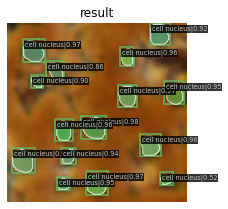

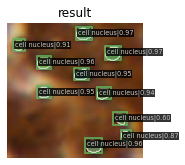

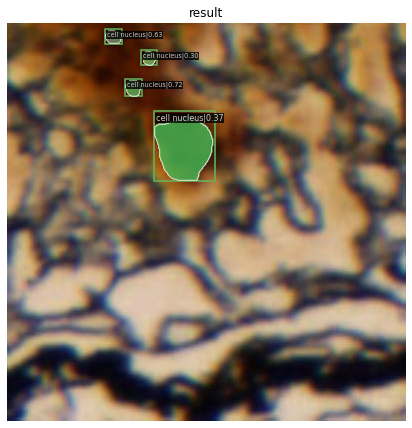

In [15]:
path_test_images = local_input_data_dir /"images_test"
path_test_images = local_input_data_dir

filelist = list((path_test_images).glob("**/*.jpg"))
filelist.extend(list((path_test_images).glob("**/*.JPG")))
filelist.extend(list((path_test_images).glob("**/*.png")))
filelist.extend(list((path_test_images).glob("**/*.PNG")))


for img_fn in random.choices(filelist, k=3):

    # img_fn = local_input_data_dir / '/images/10.jpg'
    img = mmcv.imread(img_fn)

    model.cfg = cfg
    result = inference_detector(model, img)
    show_result_pyplot(model, img, result)
    # save image with result 
    model.show_result(img, result, out_file=local_output_data_dir / f"pred_{img_fn.stem}.jpg")  

# Using pretrained model

In [16]:
# from mmdet.apis import init_detector, inference_detector
# import mmcv

# mmdetection_path = Path(mmdet.__file__).parent.parent

# # Specify the path to pretrained model config and checkpoint file
# config = cfg
# checkpoint_file = './epoch_12.pth'

# # build the model from a config file and a checkpoint file
# model = init_detector(config, checkpoint_file, device='cuda:0')

# path_test_images = local_input_data_dir

# filelist = list((path_test_images).glob("**/*.jpg"))
# filelist.extend(list((path_test_images).glob("**/*.JPG")))
# filelist.extend(list((path_test_images).glob("**/*.png")))
# filelist.extend(list((path_test_images).glob("**/*.PNG")))


# for img_fn in random.choices(filelist, k=3):

#     # img_fn = local_input_data_dir / '/images/10.jpg'
#     img = mmcv.imread(img_fn)

#     model.cfg = cfg
#     result = inference_detector(model, img)
#     show_result_pyplot(model, img, result)
#     # save image with result 
#     model.show_result(img, result, out_file=local_output_data_dir / f"pred_{img_fn.stem}.jpg") 

# Save the data

In [17]:
for img_fn in filelist:

    # img_fn = local_input_data_dir / '/images/10.jpg'
    img = mmcv.imread(img_fn)

    model.cfg = cfg
    result = inference_detector(model, img) # dulezita promenna na ziskani informaci o detekci/segmentaci # TODO: zjistit, co znamenaji cisla v promenne result
    # show_result_pyplot(model, img, result)
    # save image with result 
    model.show_result(img, result, out_file=local_output_data_dir / f"pred_{img_fn.stem}.jpg")  

In [18]:
# Result variable - getting bounding boxes or masks
# left = bbox[0]
# top = bbox[1]
# right = bbox[2]
# bottom = bbox[3]

print(result)

bboxes = result[0]
masks = result[1]

([array([[1.07260086e+02, 4.65841866e+01, 1.27513008e+02, 6.70356827e+01,
        9.56342518e-01],
       [1.55457413e+02, 1.71291779e+02, 1.75854767e+02, 1.91133438e+02,
        9.49002206e-01],
       [5.77886238e+01, 4.04942055e+01, 7.40208511e+01, 6.06079903e+01,
        9.41136777e-01],
       [1.46007950e+02, 1.41314011e+02, 1.64362991e+02, 1.62153778e+02,
        9.32126999e-01],
       [1.18848091e+02, 1.63757538e+02, 1.36707962e+02, 1.84404816e+02,
        9.20568943e-01],
       [1.41009277e+02, 7.04159241e+01, 1.58079559e+02, 9.02724991e+01,
        9.16745603e-01],
       [1.05192764e+02, 8.03761673e+01, 1.25849411e+02, 1.02680176e+02,
        9.09670830e-01],
       [1.35588665e+01, 1.87330154e+02, 3.10813065e+01, 1.98569839e+02,
        8.70696783e-01],
       [9.18298340e+01, 1.11117752e+02, 1.04162361e+02, 1.22519043e+02,
        8.68099451e-01],
       [5.52098417e+00, 3.34613762e+01, 2.33021240e+01, 5.26853294e+01,
        8.63776088e-01],
       [3.08760109e+01, 7.33

# Copy data to my home

In [19]:
# dtstr = datetime.now().strftime("%Y%m%d_%H%M")
# # dtstr = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# !mkdir -p ~/data/processed/$dtstr

# output_path = str(Path("~/data/processed").expanduser() / dtstr)
# input_path = str(scratchdir/"data/processed/")

# !cp -r "$SCRATCHDIR"/data/processed/* {output_path} 
# !ls ~/data/processed/$dtstr
# print(dtstr)
# print(input_path)
# print(output_path)

In [ ]:
import shutil, errno

def copy_files(src, dst):
    try:
        shutil.copytree(src, dst)
    except OSError as exc: # python >2.5
        if exc.errno in (errno.ENOTDIR, errno.EINVAL):
            shutil.copy(src, dst)
        else: raise
        
dtstr = datetime.now().strftime("%Y%m%d_%H%M")
# dtstr = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

input_path = str(scratchdir/"data/processed/")
output_path = str(Path("~/data/processed").expanduser() / dtstr)
        
copy_files(input_path, output_path)
!ls ~/data/processed/$dtstr

## Visualizing training with TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /auto/plzen1/home/jburian/data/processed/20230414_1614/tutorial_exps/tf_logs